In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
using LinearAlgebra, Plots
import ForwardDiff as FD
using Printf
using JLD2

  Activating project at `~/Downloads/HW1_S25-main`
┌ Warning: The active manifest file is an older format with no julia version entry. Dependencies may have been resolved with a different julia version.
└ @ ~/Downloads/HW1_S25-main/Manifest.toml:0


# Q3 (31 pts): Log-Domain Interior Point Quadratic Program Solver

Here we are going to use the log-domain interior point method described in Lecture 5 to create a QP solver for the following general problem:

$$\begin{align}
\min_x \quad & \frac{1}{2}x^TQx + q^Tx \\ 
\text{s.t.}\quad &  Ax -b = 0 \\ 
&  Gx - h \geq 0 
\end{align}$$
where the cost function is described by $Q \in \mathbb{R}^{n \times n}$, $q \in \mathbb{R}^n$, an equality constraint is described by $A \in \mathbb{R}^{m \times n}$ and $b \in \mathbb{R}^m$, and an inequality constraint is described by $G \in \mathbb{R}^{p \times n}$ and $h \in \mathbb{R}^p$.

We'll first walk you through the steps to reformulate the problem into an interior point log-domain form that we can solve.

## Part (A): KKT Conditions (2 pts)
To reduce ambiguity (and make sure the test cases pass) for the KKT conditions, make sure that the stationarity condition term for the equality constraint is ($ + A^T\mu$) (not minus). The sign on $G^T\lambda$ is determined by the condition $\lambda \geq 0$.


**TASK**: Introduce Lagrange multipliers $\mu$ for the equality constraint, and $\lambda$ for the inequality constraint and fill in the following for the KKT conditions for the QP. For complementarity use the $\circ$ symbol (i.e. $a \circ b = 0$)

$$\begin{align}
Qx + q + A^T \mu + G^T \lambda &= 0 \quad \quad \text{(stationarity)} \\
Ax - b &= 0 \quad \quad \text{(primal feasibility)} \\
Gx - h - s &\geq 0 \quad \quad \text{(primal feasibility)} \\
\lambda &\geq 0 \quad \quad \text{(dual feasibility)} \\
\lambda \circ s &= 0 \quad \quad \text{(complementarity)} 
\end{align}$$

## Part (B): Relaxed Complementarity (2 pts)

In order to apply the log-domain trick, we can introduce a slack variable to represent our inequality constraints ($s$). This new variable lets us enforce the inequality constraint ($s \geq 0$) by using a log-domain substitution which is always positive by construction. 

We'll also relax the complementarity condition as shown in class.

**TASK**: Modify your KKT conditions by doing the following:
1. Add a slack variable to split the primal feasibility $Gx - h \geq 0$ condition into $Gx - h = s$ and $s \geq 0$
2. Relax the complementarity condition so $\lambda \circ s = 0$ becomes $\lambda \circ s = 1^T\rho$ where $\rho$ will be some positive barrier parameter and $1$ is a vector of ones.

Write down the KKT conditions (there should now be six) after you've done the above steps.

$$\begin{align}
Qx + q + A^T \mu + G^T \lambda &= 0 \quad \quad \text{(stationarity)} \\
Ax - b &= 0 \quad \quad \text{(primal feasibility)} \\
Gx - h - s &= 0 \quad \quad \text{(primal feasibility with slack variable)} \\
s &\geq 0 \quad \quad \text{(slack variable constraint)} \\
\lambda &\geq 0 \quad \quad \text{(dual feasibility)} \\
\lambda \circ s &= 1^T \rho \quad \quad \text{(relaxed complementarity)}
\end{align}$$

## Part (C): Log-domain Substitution (2 pts)

Finally, to enforce positivity on both $\lambda$ and $s$, we can perform a variable substitution. By using a particular substitution $\lambda = \sqrt\rho e^{-\sigma}$ and $s = \sqrt\rho e^\sigma$ we can also make sure that our relaxed complementarity condition $\lambda \circ s = 1^T\rho$ is always satisfied. 

**TASK**: Finally do the following:
1. Define a new variable $\sigma$ and define $\lambda = \sqrt\rho e^{-\sigma}$ and $s = \sqrt\rho e^\sigma$. 
2. Replace $\lambda$ and $s$ in your KKT conditions with the new definitions

Three of your KKT conditions from (B) should now be satisfied by construction. Write down the remaining 3 KKT conditions (hint: they should all be $=0$ and the only variables should be x, $\mu$, and $\sigma$).

$$\begin{align}
Qx + q + A^T \mu + G^T (\sqrt{\rho} e^{-\sigma}) &= 0 \quad \quad \text{(stationarity)} \\
Ax - b &= 0 \quad \quad \text{(primal feasibility)} \\
Gx - h - \sqrt{\rho} e^{\sigma} &= 0 \quad \quad \text{(primal feasibility with slack variable substitution)}
\end{align}$$

## Part (D): Log-domain Interior Point Solver
We can now write our solver! You'll implement two residual functions (matching your residuals in Part A and C), and a function to solve the QP using Newton's method. The solver should work according to the following pseudocode where:
- $\rho$ is the barrier parameter
- kkt_conditions is the KKT conditions from part A
- ip_kkt_conditions is the KKT conditions from part C

```
rho = 0.1 (penalty parameter) 
for max_iters
    calculate the Newton step using ip_kkt_conditions and ip_kkt_jac
    perform a linesearch (use the same condition as in Q2, with the norm of the ip_kkt_conditions as the merit function)
    if norm(ip_kkt_conditions, Inf) < tol, update the barrier parameter
        rho = rho * 0.1
    end
    if norm(kkt_conditions, Inf) < tol
        exit
    end
end
```

In [2]:
# TODO: read below
# NOTE: DO NOT USE A WHILE LOOP ANYWHERE
"""
The data for the QP is stored in `qp` the following way:
    @load joinpath(@__DIR__, "qp_data.jld2") qp 

which is a NamedTuple, where
    Q, q, A, b, G, h, xi, μi, σi = qp.Q, qp.q, qp.A, qp.b, qp.G, qp.h

contains all of the problem data you will need for the QP.

Your job is to make the following functions where z = [x; μ; σ], λ = sqrt(ρ).*exp.(-σ), and s = sqrt(ρ).*exp.(σ)
    
    kkt_res = kkt_conditions(qp, z, ρ)
    ip_res = ip_kkt_conditions(qp, z)
    ip_jac = ip_kkt_jacobian(qp, z)
    x, λ, μ = solve_qp(qp; verbose = true, max_iters = 100, tol = 1e-8)

"""

# Helper functions (you can use or not use these)
function c_eq(qp::NamedTuple, x::Vector)::Vector
    qp.A*x - qp.b 
end
function h_ineq(qp::NamedTuple, x::Vector)::Vector
    qp.G*x - qp.h
end

"""
    kkt_res = kkt_conditions(qp, z, ρ)

Return the KKT residual from part A as a vector (make sure to clamp the inequalities!)
In Julia, use the following for elementwise min.
elementwise_min = min.(a, b) # This is elementwise min
scalar_elementwise_min = min.(a, 0) # You can also take an elementwise min with a scalar
"""
function kkt_conditions(qp::NamedTuple, z::Vector, ρ::Float64)::Vector
    x, μ, σ = z[qp.xi], z[qp.μi], z[qp.σi]

    # TODO compute λ from σ and ρ
    λ = sqrt(ρ) * exp.(-σ)

    # TODO compute and return KKT conditions
    r_stationarity = qp.Q * x + qp.q + qp.A' * μ - qp.G' * λ
    primal1 = c_eq(qp,x)
    primal2 = min.(h_ineq(qp,x),0.0)

    dual = min.(λ,0.0)
    complementary = λ .* (qp.G*x - qp.h)
    
    # error("kkt_conditions not implemented")
    # return nothing 
    return vcat(r_stationarity, primal1, primal2, dual, complementary)
end



"""
    ip_res = ip_kkt_conditions(qp, z)

Return the interior point KKT residual from part C as a vector
"""
function ip_kkt_conditions(qp::NamedTuple, z::Vector, ρ::Float64)::Vector
    x, μ, σ = z[qp.xi], z[qp.μi], z[qp.σi]
    
    # TODO compute λ and s from σ and ρ
    λ = sqrt(ρ).*exp.(-σ)
    s = sqrt(ρ).*exp.(σ)

    # TODO compute and return IP KKT conditions
    res1 = qp.Q*x + qp.q + qp.A'*μ - qp.G'*λ
    res2 = c_eq(qp, x)
    res3 = h_ineq(qp,x) - s
    return vcat(res1, res2, res3) 
end

"""
    ip_jac = ip_jacobian(qp, z, ρ)

Return the full Newton jacobian of the interior point KKT conditions (part C) with respect to z
Construct it analytically (don't use auto differentiation)
"""
function ip_kkt_jac(qp::NamedTuple, z::Vector, ρ::Float64)::Matrix
    x, μ, σ = z[qp.xi], z[qp.μi], z[qp.σi]

    # TODO: return full Newton jacobian (don't use ForwardDiff)
    n = length(x)
    m = length(μ)
    p = length(σ)

    # Derivatives for F1: Q*x + q + A'*μ + G'*(sqrt(ρ)*exp(-σ))
    J11 = qp.Q
    J12 = qp.A'
    J13 = qp.G' * diagm(0 => sqrt(ρ).*exp.(-σ))

    # Derivatives for F2: A*x - b
    J21 = qp.A
    J22 = zeros(m, m)
    J23 = zeros(m, p)

    # Derivatives for F3: G*x - h - sqrt(ρ)*exp(σ)
    J31 = qp.G
    J32 = zeros(p, m)
    J33 = - diagm(0 => sqrt(ρ).*exp.(σ))
    
    return [J11  J12  J13;
            J21  J22  J23;
            J31  J32  J33]
end

function logging(qp::NamedTuple, main_iter::Int, z::Vector, ρ::Real, α::Real)
    x, μ, σ = z[qp.xi], z[qp.μi], z[qp.σi]

    # TODO: compute λ
    λ = sqrt(ρ) .* exp.(-σ)

    # TODO: stationarity norm
    # The stationarity residual (∇Lₓ) is given by Q*x + q + A'*μ - G'*λ.
    stationarity_norm = norm(qp.Q * x + qp.q + qp.A' * μ - qp.G' * λ, Inf)

    @printf("%3d  % 7.2e  % 7.2e  % 7.2e  % 7.2e  %5.0e  %5.0e\n",
            main_iter, stationarity_norm, minimum(h_ineq(qp,x)),
            norm(c_eq(qp,x), Inf), abs(dot(λ, h_ineq(qp,x))), ρ, α)
end

"""
    x, μ, λ = solve_qp(qp; verbose = true, max_iters = 100, tol = 1e-8)

Solve the QP using the method defined in the pseudocode above, where z = [x; μ; σ], λ = sqrt(ρ).*exp.(-σ), and s = sqrt(ρ).*exp.(σ)
"""
function solve_qp(qp; verbose = true, max_iters = 100, tol = 1e-8)
    # Init solution vector z = [x; μ; σ]
    z = zeros(length(qp.q) + length(qp.b) + length(qp.h))
    
    # Set the initial barrier parameter
    ρ = 1.0

    if verbose
        @printf "iter   |∇Lₓ|      min(h)       |c|       compl     ρ      α\n"
        @printf "----------------------------------------------------------------\n"
    end

    for main_iter = 1:max_iters 
        # Compute the IP KKT residual and its Jacobian
        r = ip_kkt_conditions(qp, z, ρ)
        M = ip_kkt_jac(qp, z, ρ)
        Δz = -M \ r

        # Line search parameters
        α = 1.0
        b = 0.1
        c = 0.5
        for ls_iter in 1:1000
            if norm(ip_kkt_conditions(qp, z + α * Δz, ρ)) <= (norm(r) + b * α * dot(r, M * Δz) / norm(r))
                break
            end
            α = c * α
        end

        # Update the iterate
        z = z + α * Δz

        if verbose
            logging(qp, main_iter, z, ρ, α) 
        end

        if norm(ip_kkt_conditions(qp, z, ρ), Inf) < tol
            ρ = ρ * 0.1
        end

        if norm(kkt_conditions(qp, z, ρ), Inf) < tol
            x = z[qp.xi]
            μ = z[qp.μi]
            σ = z[qp.σi]
            λ = sqrt(ρ) .* exp.(-σ)
            return x, μ, λ
        end
    end
    x = z[qp.xi]
    μ = z[qp.μi]
    σ = z[qp.σi]
    λ = sqrt(ρ) .* exp.(-σ)
    return x, μ, λ
end





solve_qp

### QP Solver test

In [3]:
# 10 points 
using Test 
@testset "qp solver" begin 
    @load joinpath(@__DIR__, "qp_data.jld2") qp 
    x, λ, μ = solve_qp(qp; verbose = true, max_iters = 100, tol = 1e-6)
    
    @load joinpath(@__DIR__, "qp_solutions.jld2") qp_solutions
    @test norm(kkt_conditions(qp, qp_solutions.z, qp_solutions.ρ))<1e-3;
    @test norm(ip_kkt_conditions(qp, qp_solutions.z, qp_solutions.ρ))<1e-3;
    @test norm(ip_kkt_jac(qp, qp_solutions.z, qp_solutions.ρ) - FD.jacobian(dz -> ip_kkt_conditions(qp, dz, qp_solutions.ρ), qp_solutions.z), Inf) < 1e-3
    @test norm(x - qp_solutions.x,Inf)<1e-3;
    println("Size of μ: ", size(μ))
    println("Size of qp_solutions.μ: ", size(qp_solutions.μ))

    @test norm(λ - qp_solutions.λ,Inf)<1e-3;
    @test norm(μ - qp_solutions.μ,Inf)<1e-3;
end

iter   |∇Lₓ|      min(h)       |c|       compl     ρ      α
----------------------------------------------------------------
  1   5.52e-01   5.80e-01   1.78e-15   4.45e+00  1e+00  1e+00
  2   1.98e-02   7.22e-01   8.88e-16   4.96e+00  1e+00  1e+00
  3   1.44e-04   7.30e-01   2.22e-16   5.00e+00  1e+00  1e+00
  4   2.12e-08   7.30e-01   2.22e-16   5.00e+00  1e+00  1e+00
  5   1.62e+00  -8.10e-02   4.44e-16   1.76e-01  1e-01  1e+00
  6   2.07e-01   8.02e-02   8.88e-16   4.70e-01  1e-01  1e+00
  7   6.79e-03   8.99e-02   8.88e-16   4.98e-01  1e-01  1e+00
  8   9.09e-06   9.03e-02   8.88e-16   5.00e-01  1e-01  1e+00
  9   2.34e-10   9.03e-02   8.88e-16   5.00e-01  1e-01  1e+00
 10   4.43e-01   3.03e-02   2.22e-16   9.05e-02  1e-02  5e-01
 11   1.73e-02   9.16e-03   2.22e-16   4.93e-02  1e-02  1e+00
 12   9.53e-05   9.28e-03   8.88e-16   5.00e-02  1e-02  1e+00
 13   6.87e-09   9.28e-03   8.88e-16   5.00e-02  1e-02  1e+00
 14   2.31e-01   2.98e-03   2.22e-16   8.59e-03  1e-03  5e-01
 15   7

Test.DefaultTestSet("qp solver", Any[], 6, false, false, true, 1.740692310989718e9, 1.740692313830618e9, false, "In[3]")

# Simulating a Falling Brick with QPs
In this question we'll be simulating a brick falling and sliding on ice in 2D. You will show that this problem can be formulated as a QP, which you will solve using an Interior Point method.

## The Dynamics
The dynamics of the brick can be written in continuous time as
$$ M \dot{v}  + M g = J^T \mu \\ \text{ where } M = mI_{2\times 2}, \; g = \begin{bmatrix} 0 \\ 9.81 \end{bmatrix},\; J = \begin{bmatrix} 0 & 1 \end{bmatrix} $$
and $\mu \in \mathbb{R}$ is the normal force. The velocity $v \in \mathbb{R}^2$ and position $q \in \mathbb{R}^2$ are composed of the horizontal and vertical components.

We can discretize the dynamics with backward Euler:
$$ \begin{bmatrix} v_{k+1} \\ q_{k+1} \end{bmatrix} = \begin{bmatrix} v_k \\ q_k \end{bmatrix}
+ \Delta t \cdot \begin{bmatrix} \frac{1}{m} J^T \mu_{k+1} - g \\ v_{k+1} \end{bmatrix}$$

We also have the following contact constraints:
$$ \begin{align}
J q_{k+1} &\geq 0 &&\text{(don't fall through the ice)} \\
\mu_{k+1} &\geq 0 &&\text{(normal forces only push, not pull)} \\
\mu_{k+1} J q_{k+1} &= 0 &&\text{(no force at a distance)}
\end{align} $$

## Part (E): QP formulation for Falling Brick (5 pts)
Show that these discrete-time dynamics are equivalent to the following QP by writing down the KKT conditions.

$$ \begin{align}
    &\text{minimize}_{v_{k+1}} && \frac{1}{2} v_{k+1}^T M v_{k+1} + [M (\Delta t \cdot g - v_k)]^Tv_{k+1} \\
    &\text{subject to} && J(q_k + \Delta t \cdot v_{k+1}) \geq 0 \\
\end{align} $$

**TASK**: Write down the KKT conditions for the optimization problem above, and show that it's equivalent to the dynamics problem stated previously. Use LaTeX markdown.

The KKT conditions for the quadratic program are:

\begin{align}
    M v_{k+1} + M (\Delta t \cdot g - v_k) - \Delta t J^T \lambda &= 0 \quad \quad \text{(stationarity)} \\
    J(q_k + \Delta t \cdot v_{k+1}) &\geq 0 \quad \quad \text{(primal feasibility)} \\
    \lambda &\geq 0 \quad \quad \text{(dual feasibility)} \\
    \lambda \circ J(q_k + \Delta t \cdot v_{k+1}) &= 0 \quad \quad \text{(complementarity)}
\end{align}

The stationarity condition from the KKT conditions is:

\begin{equation}
    M v_{k+1} + M (\Delta t \cdot g - v_k) - \Delta t J^T \lambda = 0.
\end{equation}

Rearranging:

\begin{equation}
    M v_{k+1} + M \Delta t g - M v_k = \Delta t J^T \lambda.
\end{equation}

Dividing by $\Delta t$:

\begin{equation}
    M \frac{v_{k+1} - v_k}{\Delta t} + M g = J^T \lambda.
\end{equation}

This matches the discrete-time version of the original dynamics equation:

\begin{equation}
    M \dot{v} + M g = J^T \mu.
\end{equation}

Thus, we identify $\lambda = \mu_{k+1}$, confirming that the stationarity condition enforces the correct equations of motion.

\subsection*{2. Contact Constraints}
The QP includes the constraint:

\begin{equation}
    J(q_k + \Delta t \cdot v_{k+1}) \geq 0.
\end{equation}

Expanding,

\begin{equation}
    Jq_k + \Delta t J v_{k+1} \geq 0.
\end{equation}

This ensures that the brick does not fall through the ice, aligning with the original problem constraint $Jq_{k+1} \geq 0$.

From the KKT conditions:

\begin{align}
    \lambda &\geq 0 \quad \quad \text{(normal forces only push, not pull)} \\
    \lambda \circ J(q_k + \Delta t \cdot v_{k+1}) &= 0 \quad \quad \text{(no force at a distance)}.
\end{align}

\begin{align}
    J q_{k+1} &\geq 0, \\
    \mu_{k+1} &\geq 0, \\
    \mu_{k+1} J q_{k+1} &= 0.
\end{align}

Since we identified $\lambda = \mu_{k+1}$, these conditions are equivalent.

By deriving the stationarity condition and showing that the contact constraints match, we have demonstrated that the KKT conditions recover the original discrete-time dynamics of the falling brick.

## Part (F): Brick Simulation (5 pts)

In [4]:
function brick_simulation_qp(q, v; mass = 1.0, Δt = 0.01)
    
    # Fill in Q as mass*I₂ (here mass=1.0 so it is just the 2×2 identity)
    Q_filled = mass * Matrix{Float64}(I, 2, 2)
    
    # Define the acceleration due to gravity (downward)
    g = [0.0, -9.81]
    
    # Fill in q such that the unconstrained optimum is v + Δt * g.
    # With an objective 1/2 * v'Qv + q'v and Q = I, the optimum is v* = -q.
    # Therefore, we set:
    q_filled = - (v + Δt * g)
    
    # The brick must not penetrate the ground.
    # The new position is q_new = q + Δt * v_new, so the constraint is:
    #   q[2] + Δt * v_new[2] >= 0.
    # Writing this in the form G*v_new - h >= 0, we choose:
    G_filled = [0.0  Δt]   # a 1×2 row vector
    h_filled = [-q[2]]      # a 1-element vector
    
    qp = (
        Q = Q_filled, 
        q = q_filled,
        A = zeros(0,2), # don't edit this
        b = zeros(0),   # don't edit this 
        G = G_filled,
        h = h_filled,
        xi = 1:2,       # don't edit this
        μi = [],        # don't edit this
        σi = 3:3        # don't edit this
    )
    
    return qp 
end


brick_simulation_qp (generic function with 1 method)

In [5]:
@testset "brick qp" begin 
    
    q = [1,3.0]
    v = [2,-3.0]
    
    qp = brick_simulation_qp(q,v)
    
    # check all the types to make sure they're right
    qp.Q::Matrix{Float64}
    qp.q::Vector{Float64}
    qp.A::Matrix{Float64}
    qp.b::Vector{Float64}
    qp.G::Matrix{Float64}
    qp.h::Vector{Float64}
    
    @test size(qp.Q) == (2,2)
    @test size(qp.q) == (2,)
    @test size(qp.A) == (0,2)
    @test size(qp.b) == (0,)
    @test size(qp.G) == (1,2)
    @test size(qp.h) == (1,)
    
    @test abs(tr(qp.Q) - 2) < 1e-10
    @test norm(qp.q - [-2.0, 3.0981]) < 1e-10 
    @test norm(qp.G - [0 .01]) < 1e-10 
    @test abs(qp.h[1] - -3) < 1e-10
    
end

Test Summary: | Pass  Total  Time
brick qp      |   10     10  0.1s


Test.DefaultTestSet("brick qp", Any[], 10, false, false, true, 1.740692314186659e9, 1.740692314265446e9, false, "In[5]")

#= In[6]:30 =# @test(abs(maximum(ys) - 2) < 0.1) = Test Passed
#= In[6]:31 =# @test(minimum(ys) > -0.01) = Test Passed
#= In[6]:32 =# @test(abs(xs[end] - 3) < 0.01) = Test Passed
#= In[6]:35 =# @test(maximum(xdot) < 1.0001) = Test Passed
#= In[6]:36 =# @test(minimum(xdot) > 0.9999) = Test Passed
#= In[6]:37 =# @test(ys[110] > 0.01) = Test Passed
#= In[6]:38 =# @test(abs(ys[111]) < 0.01) = Test Passed
#= In[6]:39 =# @test(abs(ys[112]) < 0.01) = Test Passed


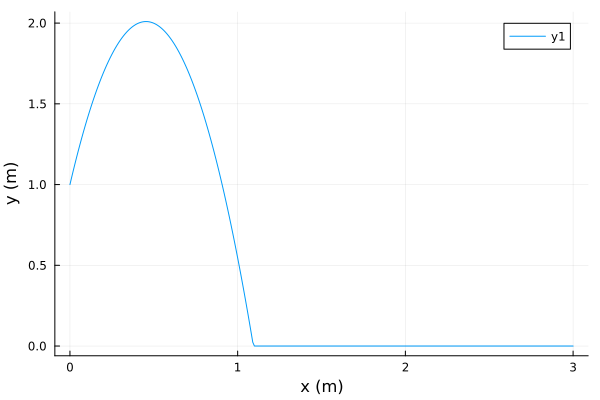

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8712


LoadError: MethodError: no method matching MeshCat.Animation(::Visualizer; fps::Int64)

[0mClosest candidates are:
[0m  MeshCat.Animation(::Any, [91m::Any[39m)[91m got unsupported keyword argument "fps"[39m
[0m[90m   @[39m [36mMeshCat[39m [90m~/.julia/packages/MeshCat/vWPbP/src/[39m[90m[4manimations.jl:49[24m[39m
[0m  MeshCat.Animation([91m::Dict{MeshCat.SceneTrees.Path, MeshCat.AnimationClip}[39m, [91m::Int64[39m)[91m got unsupported keyword argument "fps"[39m
[0m[90m   @[39m [36mMeshCat[39m [90m~/.julia/packages/MeshCat/vWPbP/src/[39m[90m[4manimations.jl:49[24m[39m
[0m  MeshCat.Animation()[91m got unsupported keyword argument "fps"[39m
[0m[90m   @[39m [36mMeshCat[39m [90m~/.julia/packages/MeshCat/vWPbP/src/[39m[90m[4manimations.jl:59[24m[39m
[0m  ...


In [6]:
include(joinpath(@__DIR__, "animate_brick.jl"))
let 
    
    dt = 0.01 
    T = 3.0 
    
    t_vec = 0:dt:T
    N = length(t_vec)
    
    qs = [zeros(2) for i = 1:N]
    vs = [zeros(2) for i = 1:N]
    
    qs[1] = [0, 1.0]
    vs[1] = [1, 4.5]
    
    # TODO: simulate the brick by forming and solving a qp 
    # simulate the brick by forming and solving a qp 
    # at each timestep. Your QP should solve for vs[k+1], and
    # you should use this to update qs[k+1]
    for k in 1:(N-1)
        qp = brick_simulation_qp(qs[k], vs[k], Δt=dt)
        vs[k+1], _, _ = solve_qp(qp; verbose=false, tol=1e-4, max_iters=150)
        qs[k+1] = qs[k] + dt * vs[k+1]
    end


    xs = [q[1] for q in qs]
    ys = [q[2] for q in qs]
    
    @show @test abs(maximum(ys)-2)<1e-1
    @show @test minimum(ys) > -1e-2
    @show @test abs(xs[end] - 3) < 1e-2
    
    xdot = diff(xs)/dt
    @show @test maximum(xdot) < 1.0001
    @show @test minimum(xdot) > 0.9999
    @show @test ys[110] > 1e-2
    @show @test abs(ys[111]) < 1e-2
    @show @test abs(ys[112]) < 1e-2
    
    display(plot(xs, ys, ylabel = "y (m)", xlabel = "x (m)"))
    
    animate_brick(qs)
    
    
    
end

# Part G (5 pts): Solve a QP

Use your QP solver to solve the following optimization problem:


$$
\begin{align} 
\min_{y\in\mathbb{R}^2,a\in\mathbb{R},b\in\mathbb{R}} \quad & \frac{1}{2}y^T \begin{bmatrix} 1 & .3 \\ .3 & 1 \end{bmatrix} y + a^2 + 2b^2  + \begin{bmatrix} -2 & 3.4 \end{bmatrix} y + 2a + 4b \\ 
\text{st} \quad & a + b = 1 \\ 
& \begin{bmatrix}-1 & 2.3 \end{bmatrix} y + a - 2b =3 \\
& -0.5 \leq y \leq 1 \\ 
& -1 \leq a \leq 1 \\ 
& -1 \leq b \leq 1
\end{align}
$$

You should be able to put this into our standard QP form that we used above, and solve.

In [7]:
@testset "part D" begin

    y = randn(2)
    a = randn()
    b = randn()

    Q = [1.0   0.3   0.0  0.0;
         0.3   1.0   0.0  0.0;
         0.0   0.0   2.0  0.0;
         0.0   0.0   0.0  4.0]
    q_vec = [-2.0, 3.4, 2.0, 4.0]

    A = [ 0.0   0.0   1.0   1.0;
         -1.0   2.3   1.0  -2.0]
    beq = [1.0, 3.0]

    G = [ 1.0   0.0   0.0   0.0;
         -1.0   0.0   0.0   0.0;
          0.0   1.0   0.0   0.0;
          0.0  -1.0   0.0   0.0;
          0.0   0.0   1.0   0.0;
          0.0   0.0  -1.0   0.0;
          0.0   0.0   0.0   1.0;
          0.0   0.0   0.0  -1.0]
    h_vec = [-0.5, -1.0, -0.5, -1.0, -1.0, -1.0, -1.0, -1.0]

    qp = (
        Q = Q,
        q = q_vec,
        A = A,
        b = beq,
        G = G,
        h = h_vec,
        xi = 1:4,
        μi = 5:6,
        σi = 7:14
    )

    x, μ, λ = solve_qp(qp)

    y = x[1:2]
    a = x[3]
    b = x[4]

    @test norm(y - [-0.080823; 0.834424]) < 1e-3 
    @test abs(a - 1) < 1e-3 
    @test abs(b) < 1e-3 
end



iter   |∇Lₓ|      min(h)       |c|       compl     ρ      α
----------------------------------------------------------------
  1   9.31e-01  -3.65e-01   4.44e-16   4.80e+00  1e+00  1e+00
  2   1.22e+00  -1.99e-01   0.00e+00   4.98e+00  1e+00  5e-01
  3   9.11e-01  -6.84e-02   0.00e+00   5.81e+00  1e+00  5e-01
  4   6.16e-01   3.66e-04   4.44e-16   6.58e+00  1e+00  5e-01
  5   4.26e-01   6.78e-02   0.00e+00   7.78e+00  1e+00  1e+00
  6   2.29e-02   6.65e-02   4.44e-16   7.99e+00  1e+00  1e+00
  7   4.32e-05   6.65e-02   1.11e-16   8.00e+00  1e+00  1e+00
  8   8.18e-11   6.65e-02   0.00e+00   8.00e+00  1e+00  1e+00
  9   3.53e+00   3.77e-02   4.44e-16   3.18e-01  1e-01  1e+00
 10   5.15e+00  -2.85e-02   4.44e-16   1.68e-01  1e-01  1e+00
 11   8.64e-01   1.33e-02   2.22e-16   7.38e-01  1e-01  1e+00
 12   3.43e-02   1.57e-02   0.00e+00   7.97e-01  1e-01  1e+00
 13   3.52e-05   1.58e-02   0.00e+00   8.00e-01  1e-01  1e+00
 14   9.56e-10   1.58e-02   0.00e+00   8.00e-01  1e-01  1e+00
 15   1

Test.DefaultTestSet("part D", Any[], 3, false, false, true, 1.740692317709054e9, 1.740692317806808e9, false, "In[7]")